# Welcome to the functional connectivity analysis tutorial!

Medusa's connectivity module implements several methods focused on analyzing the relationship
between the signals recorded at different sensors. This methodology provides a global view of
the relationships between brain activity in different regions. In this sense, the different
methods implemented in Medusa return adjacency matrices, i.e., matrices in which the off-diagonal
elements account for the connectivity value between two sensors or two signal sources.

Within the Medusa's connectivity module we can find two sub-categories: **connectivity based on
signal phase**, and **connectivity based on signal amplitude**.

This notebook will cover the main functions of the module through illustrative examples that will
allow you to get started in biosignal analysis with Medusa.

In this notebook you will learn:
    - Download an open EEG dataset and explore the files
    - Pre-process the EEG signal with Medusa filters
    - Know the different phase-based connectivity methods
    - Know the different amplitude-based connectivity methods
    - Get some plots with Medusa's plot functions

Do not forget to check the documentation if you do not understand something!

## Imports

Import the modules that will be used in this notebook.

In [2]:
# General imports
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import numpy as np
from tabulate import tabulate
import glob

# Medusa imports
from medusa import components
from medusa.meeg import meeg
from medusa import transforms
from medusa.spatial_filtering import car
from medusa.frequency_filtering import FIRFilter
from medusa.connectivity import phase_connectivity,amplitude_connectivity
from medusa.epoching import get_epochs
from medusa.plots.head_plots import plot_connectivity, plot_head

You should consider upgrading via the 'D:\MEDUSA\medusa-tutorials\venv\Scripts\python.exe -m pip install --upgrade pip' command.


## Download the dataset

As strong supporters of open science, we have released and adapted some
valuable datasets that can be very useful for researchers and practitioners.
These datasets can be downloaded manually from www.medusabci.com/datasets/ or
using a simple API. In this case, we will use the API. Run the following cell
to download the GIB-UVa ERP dataset [1].

Each file is an instance of medusa.data_structures.Recording. This class
contains the information of the performed experiment and the recorded biosignals
In this case, the recordings contain an instance of
medusa.components.ERPSpellerData, which is the default class for this
experiment. Additionally, all recordings contain a medusa.meeg.EEG instance.

In [3]:
#This functionality is not yet implemented, so the code needed to generate a synthetic signal is included.

# dataset_folder = os.getcwd()
print('WARNING: This functionality is not yet implemented, so a synthetic signal is used instead!')
# Signal parameters
l_cha = ['F7','F3','FZ','F4','F8','FCz','C3','CZ','C4','CPz','P3','PZ','P4',
         'PO7','POZ','PO8'] # Channel labels
fs = 256 # Sampling frequency
T = 120 # Signal duration
times = np.arange(0,T,1/fs) # Times vector
freqs = [4, 10, 13] # Fundamental signal frequencies
A_freqs = [1.2, 0.8, 0.5] # Frequencies amplitudes
A_noise = 1 # Noise amplitude
sigma = 0.75 # Gaussian noise variance
ps = np.linspace(0,-np.pi/2,len(l_cha)) # Phase differences between channels

# Define signal
signal = np.empty((len(times),len(l_cha)))
for c in range(len(l_cha)):
    signal[:,c] = A_freqs[0] * np.sin(2 * np.pi * freqs[0] * times - ps[c]) + A_freqs[1] * np.sin(
        2 * np.pi * freqs[1] * times - ps[c]) + A_freqs[2] * np.sin(2 * np.pi * freqs[2] * times - ps[c]) + A_noise * np.random.normal(
            0, sigma, size=times.shape)

# Create a channel set
ch_set = meeg.meeg.EEGChannelSet()
ch_set.set_standard_montage(l_cha=l_cha,montage='10-05')

print("If you have run this cell, you must not run the following cell (Explore de EEG file)")

# Print some info of the extracted features
data_exploration = [
    ['Sampling rate (Hz)', fs],
    ['Channel labels', ch_set.l_cha],
    ['Signal duration (s)', T]]

print('\nData exploration: \n')
print(tabulate(data_exploration))

If you have run this cell, you must not run the following cell (Explore de EEG file)

Data exploration: 

-------------------  -----------------------------------------------------------------------------------------------------
Sampling rate (Hz)   256
Channel labels       ['F7', 'F3', 'FZ', 'F4', 'F8', 'FCZ', 'C3', 'CZ', 'C4', 'CPZ', 'P3', 'PZ', 'P4', 'PO7', 'POZ', 'PO8']
Signal duration (s)  120
-------------------  -----------------------------------------------------------------------------------------------------


## Explore the EEG file

Once we have downloaded the EEG recording dataset, we will import the files and extract
interesting information such as the channels used, the sampling frequency, or a copy of the signal.

In [4]:
# Load one recording from the dataset
# folder = 'data'
# file_pattern = '*.rec.bson'
# files = glob.glob('%s/%s' % (folder, file_pattern))
# recording = components.Recording.load(files[0])
#
# # Get the EEG signal and time-stamps vector from recording
# signal = recording.eeg.signal.copy()
# times = recording.eeg.times.copy()
#
# # Get the EEG Channel set and sampling rate
# ch_set = recording.eeg.channel_set
# fs = recording.eeg.fs
#
# # Print some info of the extracted features
# data_exploration = [
#     ['Sampling rate (Hz)', fs],
#     ['Channel labels', ch_set.l_cha],
#     ['Signal duration (s)', len(times)/fs]]
#
# print('\nData exploration: \n')
# print(tabulate(data_exploration))

## Signal Pre-processing

Now it is time to prepare our signal to the incoming analyses. To do so, we have to apply a proper
spacial and spectral pre-processing!

First, we will apply a re-reference to the signal using a common average reference (CAR). This is a
common process in signal pre-processing for connectivity analysis as it helps to minimize the effects
of saccadic eye movements [2].  Spectral filtering will then be performed. Because the connectivity methods
implemented in Medusa require narrow filtering, we will filter directly on the frequency bands of interest.
In this case they will be Theta (4-8 Hz), Alpha (8-13 Hz) and Beta 1 (13-20 Hz). With these filtering
we also ensure that the signal is not influenced by the DC noise component. We will use a finite impulse
response (FIR) filter with a Hamming window. Finally, the signal will be
divided into epochs of 5 seconds duration.

In [5]:
# Apply CAR
signal_c = car(signal=signal)

# Create instances of FIR filters,fit them and apply to signal
order = 500 # Order of the filter
cutoffs = [[4,8],[8,13],[13,20]]
btype = 'bandpass' # Type of the filter
window = 'hamming'
filt_method = 'filtfilt' # Filtering method
axis = 0
epochs_filtered = []
for b in cutoffs:
    fir_f = FIRFilter(order=order,cutoff=b,btype=btype,window=window,
                       filt_method=filt_method,axis=axis)
    fir_f.fit(fs)

    # Apply the FIR filter
    signal_f = fir_f.transform(signal=signal_c.copy())

    # Dived into 5 s epochs
    epochs_filtered.append(get_epochs(signal=signal_f,epochs_length=int(5*fs),
                                      stride=None,norm=None))

print("The pre-processing stage is finished!")

The pre-processing stage is finished!


## Phase-based Connectivity Analysis

Once we have correctly  pre-processed our signal, in order to apply the functional connectivity
methods based on the phase of the signal, it is necessary to extract the instantaneous phase. To
do this, we will apply the Hilbert transform to our signals, which gives us back the analytical
signal of our original signal. This is composed of a real part and an imaginary part. From them we
will extract the instantaneous phase. All this process is applied internally in the methods
implemented in Medusa.

Next, we will compute adjacency matrices employing three phase-based analysis methods widely used
in neuroscience research: **Phase Locking Value** (PLV)[3], **Phase Lag Index** (PLI)[4] and
**Weighted Phase Lag Index** (wPLI)[5].

GPU acceleration: 0
Selected device: /device:CPU:0


C:\Users\Diego\AppData\Local\Programs\Python\Python310\lib\site-packages\medusa\tensorflow_integration.py:92: UserWarning: Some medusa modules take great advantage from GPU acceleration to increase the performance of medusa. You should consider execute your program in a devicewith available GPU.
  warnings.warn('Some medusa modules take great advantage from GPU '
C:\Users\Diego\AppData\Local\Programs\Python\Python310\lib\site-packages\medusa\tensorflow_integration.py:156: UserWarning: Tensorflow configured automatically. Function tensorflow_integration.config_tensorflow should be called before for custom behaviour.
  warnings.warn('Tensorflow configured automatically. Function '


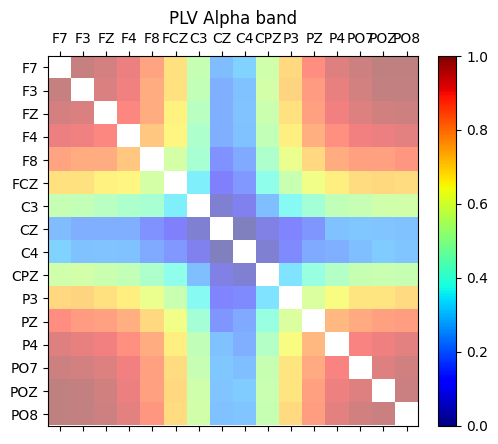

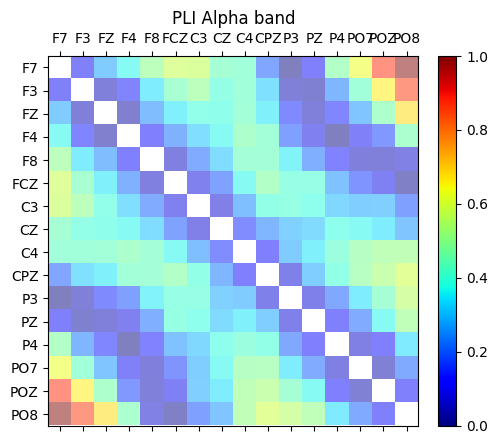

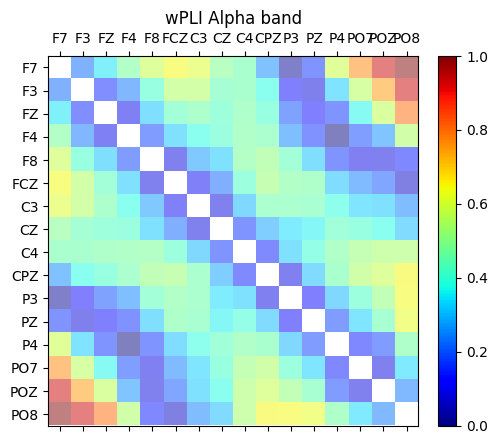

In [6]:
# Compute PLV for different frequency bands
plv_bands = []
for epochs_bands in epochs_filtered:
    plv = phase_connectivity.phase_connectivity(data=epochs_bands,
                                                           measure='plv')
    # Average epochs and remove diagonal values
    plv = np.mean(plv,axis=0)
    np.fill_diagonal(plv,np.NAN)
    plv_bands.append(plv)

# Compute PLI for different frequency bands
pli_bands = []
for epochs_bands in epochs_filtered:
    pli = phase_connectivity.phase_connectivity(data=epochs_bands,
                                                           measure='pli')
    # Average epochs and remove diagonal values
    pli = np.mean(pli,axis=0)
    np.fill_diagonal(pli,np.NAN)
    pli_bands.append(pli)

# Compute wPLI for different frequency bands
wpli_bands = []
for epochs_bands in epochs_filtered:
    wpli = phase_connectivity.phase_connectivity(data=epochs_bands,
                                                           measure='wpli')
    # Average epochs and remove diagonal values
    wpli = np.mean(wpli,axis=0)
    np.fill_diagonal(wpli,np.NAN)
    wpli_bands.append(wpli)

# Display different adjacency matrices for alpha-filtered signal averaged across epochs

# PLV
fig,ax = plt.subplots()
norm = colors.Normalize(vmin=0, vmax=1, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap="jet")
ax.matshow(plv_bands[1],cmap='jet', alpha=0.5)
ax.set_title('PLV Alpha band')
ax.set_yticks(np.arange(len(ch_set.l_cha)),labels=ch_set.l_cha)
ax.set_xticks(np.arange(len(ch_set.l_cha)),labels=ch_set.l_cha)
fig.colorbar(mapper,ax=ax,fraction=0.046,pad=0.04)

# PLI
fig,ax = plt.subplots()
norm = colors.Normalize(vmin=0, vmax=1, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap="jet")
ax.matshow(pli_bands[1],cmap='jet', alpha=0.5)
ax.set_title('PLI Alpha band')
ax.set_yticks(np.arange(len(ch_set.l_cha)),labels=ch_set.l_cha)
ax.set_xticks(np.arange(len(ch_set.l_cha)),labels=ch_set.l_cha)
fig.colorbar(mapper,ax=ax,fraction=0.046,pad=0.04)

# wPLI
fig,ax = plt.subplots()
norm = colors.Normalize(vmin=0, vmax=1, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap="jet")
ax.matshow(wpli_bands[1],cmap='jet', alpha=0.5)
ax.set_title('wPLI Alpha band')
ax.set_yticks(np.arange(len(ch_set.l_cha)),labels=ch_set.l_cha)
ax.set_xticks(np.arange(len(ch_set.l_cha)),labels=ch_set.l_cha)
fig.colorbar(mapper,ax=ax,fraction=0.046,pad=0.04)

### Connectivity plots
Medusa includes a method to represent the calculated connections by means of functional connectivity.
Let's see how the different calculated measurements look like.

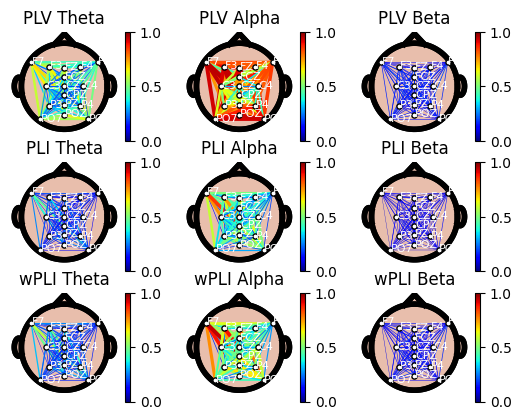

In [7]:
# Display a figure with the different connectivity measures
fig,axes = plt.subplots(3,3)
norm = colors.Normalize(vmin=0,vmax=1, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap="jet")
measures = ["PLV","PLI","wPLI"]
freq_bands = ["Theta", "Alpha","Beta"]
for r in range(3):
    for c in range(3):
        plot_head(axes=axes[r,c],channel_set=ch_set,plot_channel_labels=True)
        if r == 0:
            plot_connectivity(adj_mat=plv_bands[c],axes=axes[r,c],
                              channel_set=ch_set,
                              cmap='jet',clim=[0,1])
        elif r == 1:
            plot_connectivity(adj_mat=pli_bands[c],axes=axes[r,c],
                              channel_set=ch_set,
                              cmap='jet',clim=[0,1])
        elif r == 2:
            plot_connectivity(adj_mat=wpli_bands[c],axes=axes[r,c],
                              channel_set=ch_set,
                              cmap='jet',clim=[0,1])

        axes[r,c].set_title(measures[r] + " " + freq_bands[c])
        fig.colorbar(mapper,ax=axes[r,c],fraction=0.046,pad=0.04)


## Amplitude-based Connectivity Analysis
Amplitude-based functional connectivity measurements analyze the correlation between the
envelope of two signals. In this module Medusa implements two measurements: Amplitude Envelope
Correlation (AEC)[7] and Instantaneous Amplitude Correlation (IAC)[8]. Next, we will see how to call
the method to calculate the AEC and we will plot the results.
It should be noted that the method for calculating AEC allows the signal to be orthogonalized.
This process allows to decrease the influence of volume conduction, i.e., non-real connectivity values.

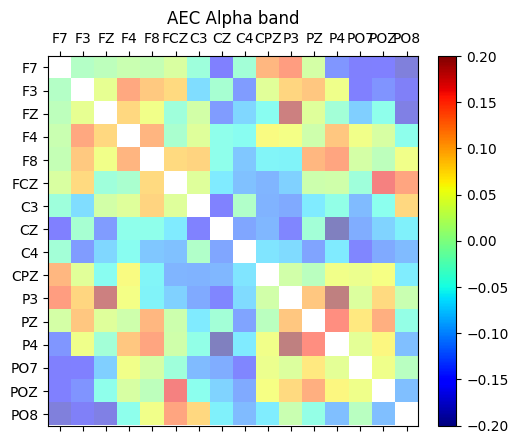

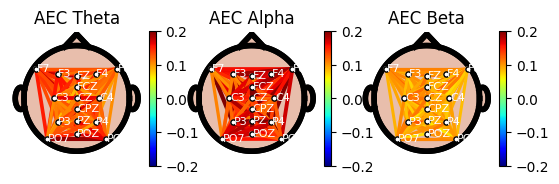

In [8]:
# Compute AEC for different frequency bands
aec_bands = []
for epochs_bands in epochs_filtered:
    aec = amplitude_connectivity.aec(data=epochs_bands, ort=True)
    # Average epochs and remove diagonal values
    aec = np.mean(aec,axis=0)
    np.fill_diagonal(aec,np.NAN)
    aec_bands.append(aec)

# AEC Alpha band
fig,ax = plt.subplots()
norm = colors.Normalize(vmin=-0.2, vmax=0.2, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap="jet")
ax.matshow(aec_bands[1],cmap='jet', alpha=0.5)
ax.set_title('AEC Alpha band')
ax.set_yticks(np.arange(len(ch_set.l_cha)),labels=ch_set.l_cha)
ax.set_xticks(np.arange(len(ch_set.l_cha)),labels=ch_set.l_cha)
fig.colorbar(mapper,ax=ax,fraction=0.046,pad=0.04)

# Display a figure with the different frequency bands
fig,axes = plt.subplots(1,3)

for c in range(3):
    plot_head(axes=axes[c],channel_set=ch_set,plot_channel_labels=True)
    plot_connectivity(adj_mat=aec_bands[c],axes=axes[c],
                          channel_set=ch_set,
                          cmap='jet',clim=[-0.2,0.2])
    axes[c].set_title("AEC " + freq_bands[c])
    fig.colorbar(mapper,ax=axes[c],fraction=0.046,pad=0.04)
plt.show()


## Conclusion
So far the Medusa-Kernel Notebook on connectivity analysis measurements! We have reviewed the main functions
of phase-based and amplitude-based connectivity analysis. We have also introduced the connectivity representation
function, very useful when you want to represent the adjacency matrices.

See you in the next tutorial!

## References

[1] https://ieee-dataport.org/documents/gib-uva-erp-bci-dataset
[2] Bachiller, A., Poza, J., Gómez, C., Molina, V., Suazo, V., & Hornero, R., _A comparative study of event-related coupling patterns during an auditory oddball task in schizophrenia_, Journal of Neural Engineering, vol. 12, no. 1, 2015.
[3] Lachaux, J. P., Rodriguez, E., Martinerie, J., & Varela, F. J., _Measuring phase synchrony in brain signals_, Human Brain Mapping, vol. 8, no. 4, p. 194–208, 1999
[4] Stam, C. J., Nolte, G., & Daffertshofer, A., _Phase lag index: Assessment of functional connectivity from multi channel EEG and MEG with diminished bias from common sources_, Human Brain Mapping, vol. 28, no. 11, p. 1178–1193, 2007
[5] Vinck, M., Oostenveld, R., Van Wingerden, M., Battaglia, F., & Pennartz, C. M. A., _An improved index of phase-synchronization for electrophysiological data in the presence of volume-conduction, noise and sample-size bias_, NeuroImage, vol. 55, no. 4, p. 1548–1565, 2011
[7] Liu, Z., Fukunaga, M., de Zwart, J. A., & Duyn, J. H., _Large-scale spontaneous fluctuations and correlations in brain electrical activity observed with magnetoencephalography_, Neuroimage, vol. 51, no. 1, p. 102-111, 2010.
[8] Tewarie, P., Liuzzi, L., O'Neill, G. C., Quinn, A. J., Griffa, A., Woolrich, M. W., Brookes, M. J., _Tracking dynamic brain networks using high temporal resolution MEG measures of functional connectivity_, Neuroimage, vol. 200, p. 38-50, 2019